
# Supernovae distances and redshifts (part 1)

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

Let's recall the definition of magnitude and the distance modulus:

$$\mu = m - M = 5\text{log}_{10}\left(\frac{d_L}{pc}\right) - 5$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored.

These are some (synthetic but realistic; see textbook) supernova data:

In [92]:
import matplotlib.pyplot as plt
import numpy as np
from astroML.datasets import generate_mu_z
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from sklearn.model_selection import GridSearchCV

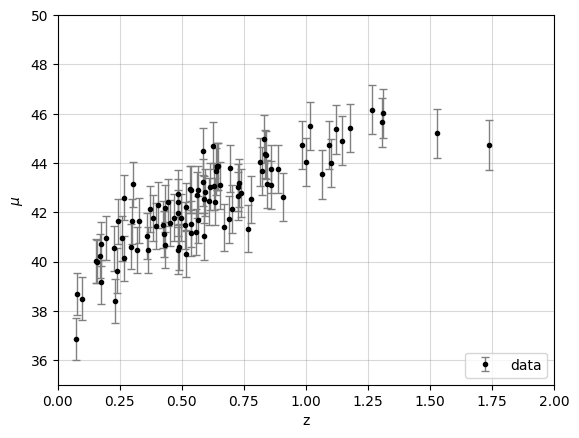

In [93]:
N = 100     # Number of samples to generate
z_sample, mu_sample, dmu = generate_mu_z(N, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1,label='data')
plt.xlabel('z')
plt.ylabel('$\\mu$')
plt.legend(loc='lower right')
plt.grid(alpha=0.3, c='gray')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()


### Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

### Linear regression

[39.56505555] [[4.64711848]]


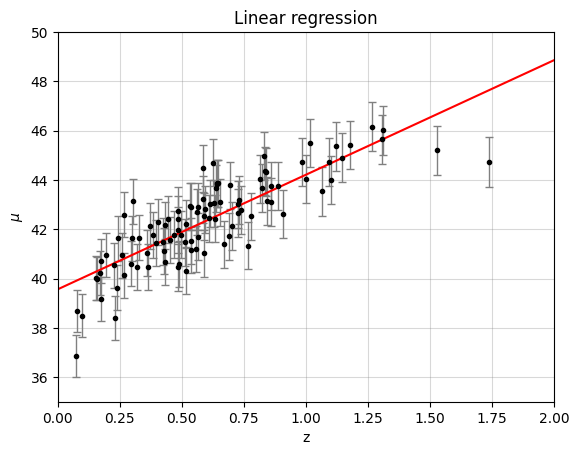

In [94]:
z = z_sample[:, np.newaxis]     # z_sample for plotting, z for fitting
mu = mu_sample[:, np.newaxis]

lin_reg = LinearRegression()
lin_reg.fit(z, mu, sample_weight=1)

theta0 = lin_reg.intercept_
theta1 = lin_reg.coef_

print(theta0, theta1)

xgrid = np.linspace(0, 2.0, 10)
Y_pred = theta0 + theta1 * xgrid

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1)
plt.plot(xgrid, Y_pred[0], c = 'red')
plt.xlabel('z')
plt.ylabel('$\\mu$')
plt.grid(alpha=0.3, c='gray')
plt.title('Linear regression')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

### Polynomial regression

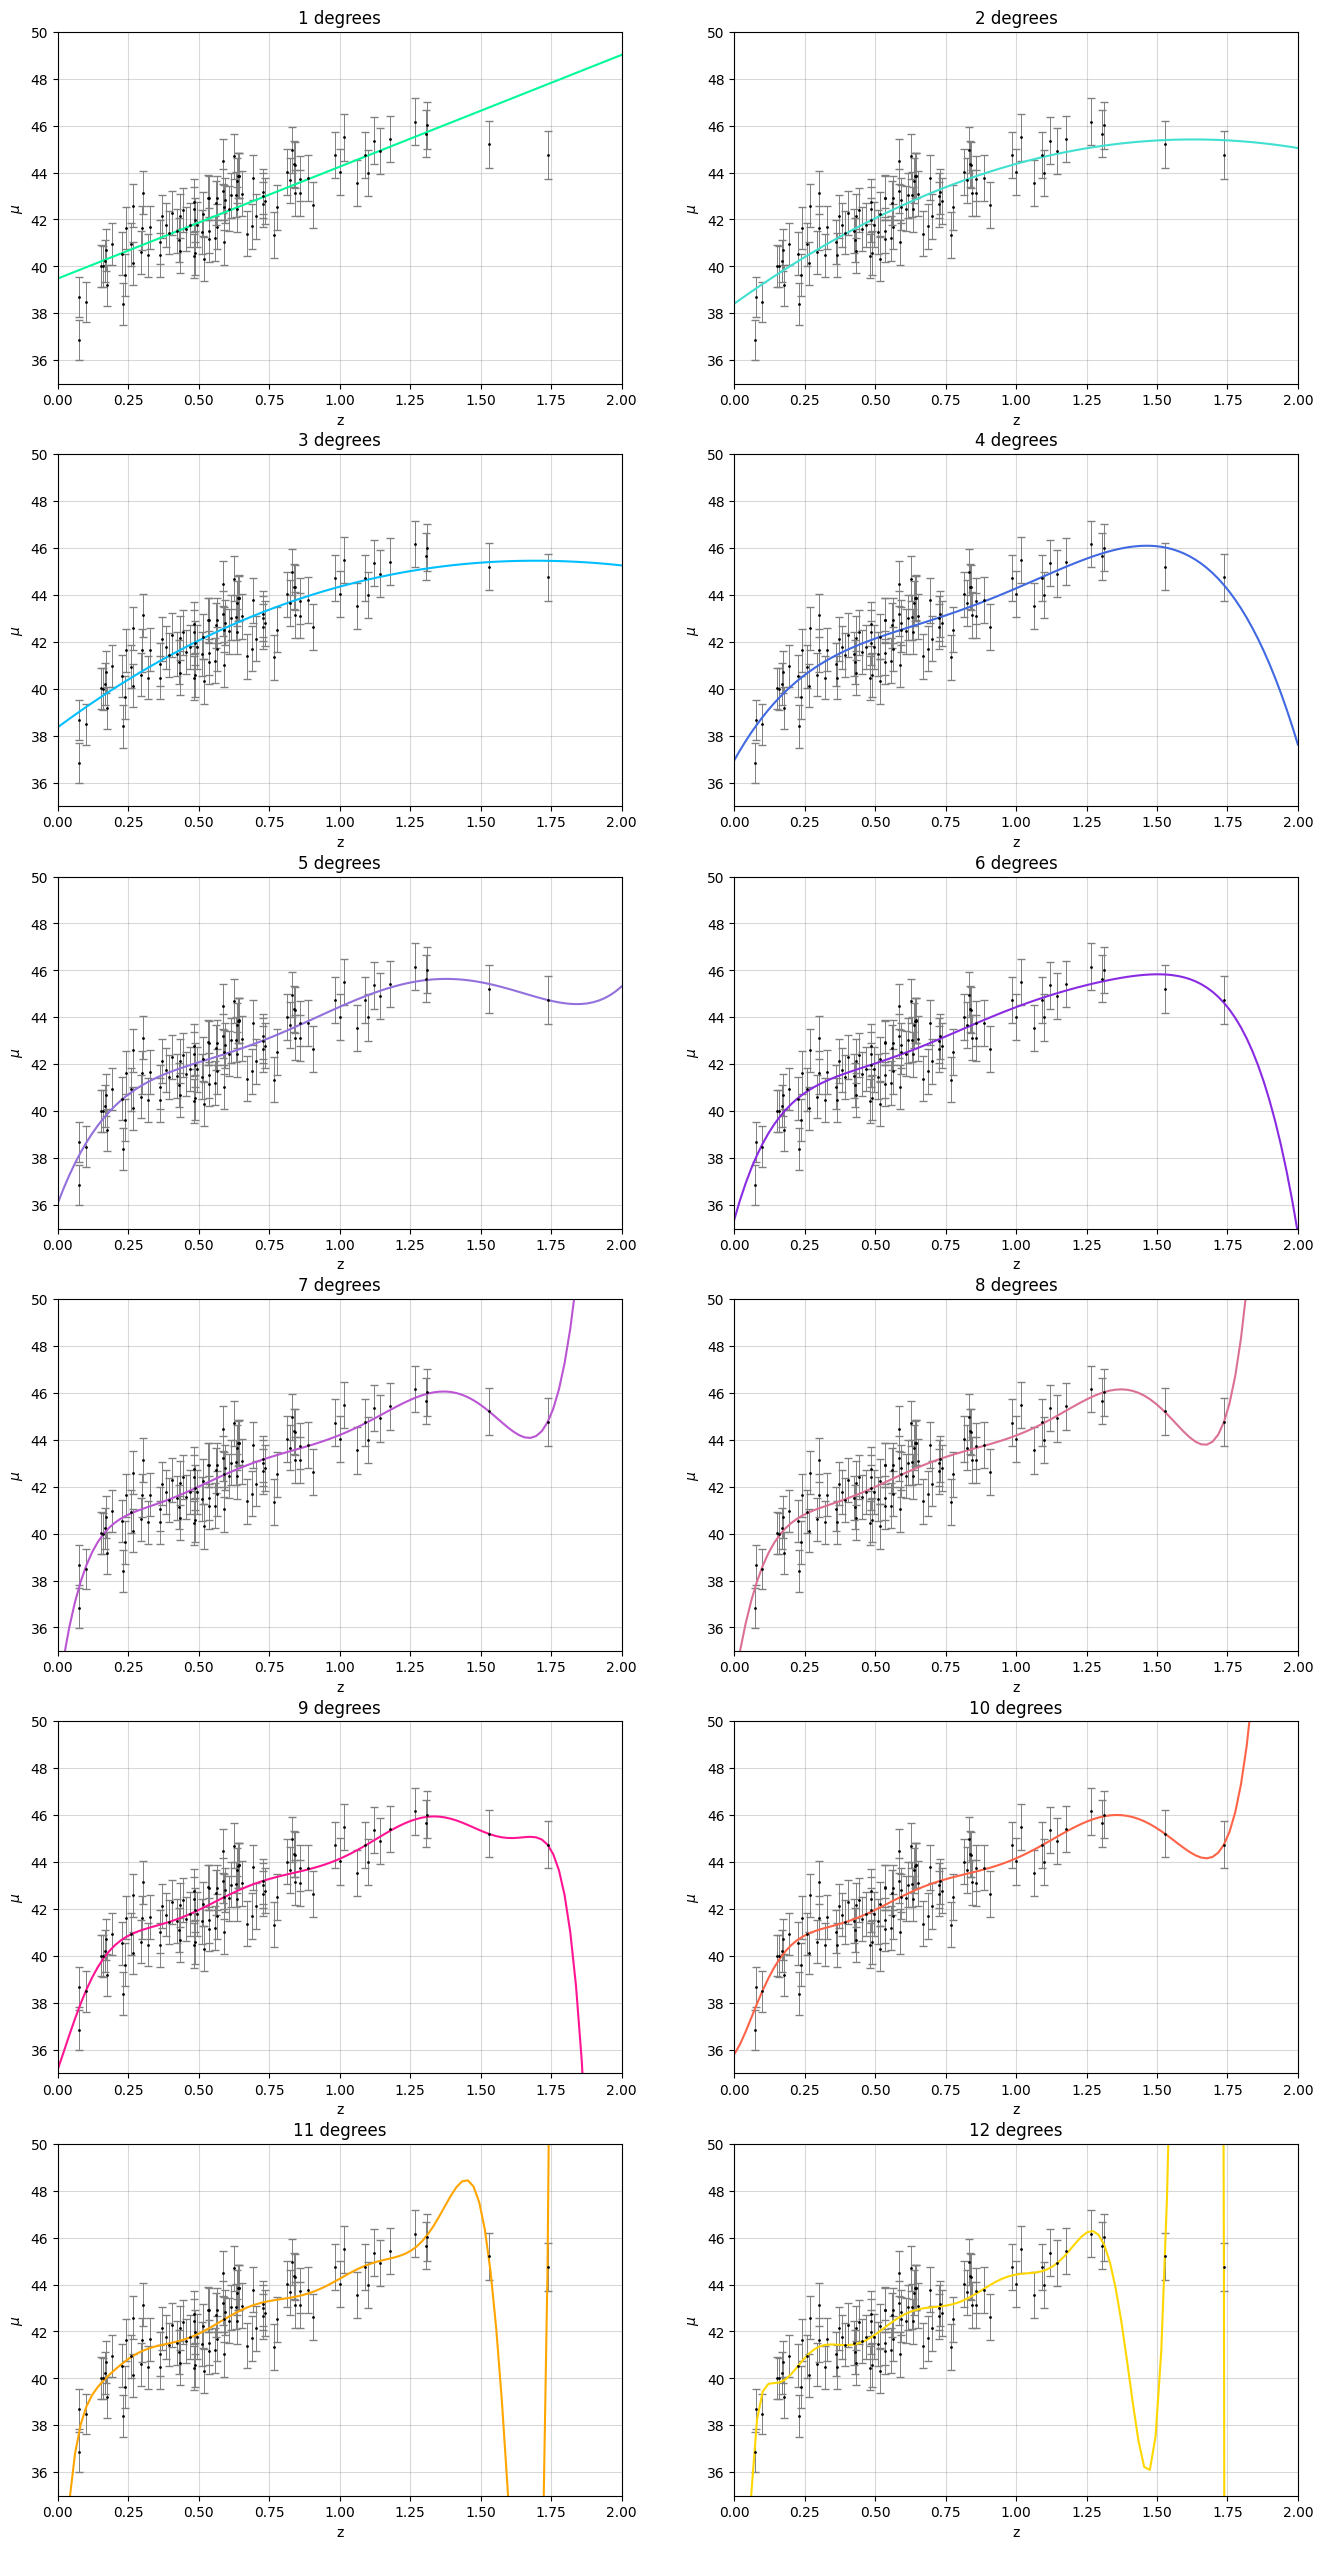

In [95]:
X_points = np.linspace(0, 2.0, 100)
xgrid = X_points[:, np.newaxis]

fig = plt.figure(figsize=(16, 32))

colors = ['mediumspringgreen', 'turquoise', 'deepskyblue', 'royalblue', 'mediumpurple', 'blueviolet', 'mediumorchid', 'palevioletred', 'deeppink', 'tomato', 'orange', 'gold']
degrees = np.arange(1, 13)

for i, degree in enumerate(degrees):
    ax = fig.add_subplot(6,2,1+i)
    plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ms = 2, ecolor='gray', elinewidth = 0.7, capsize=3, lw=1)
    
    model = PolynomialRegression(degree)
    model.fit(z, mu_sample, dmu)     # z.shape = (100, 1), mu.shape = (100, 1), PolynomialRegression wants the y to be (100, ) ---> using mu_sample
    y_poly = model.predict(xgrid)
    
    plt.plot(xgrid, y_poly, lw = 1.5, color = colors[i])
    plt.xlabel('z')
    plt.ylabel('$\\mu$')
    plt.grid(alpha=0.3, c='gray')
    plt.title('%i degrees' % degree)
    plt.xlim(0,2)
    plt.ylim(35,50)
    
plt.show()

Judging by these plots, the linear fit seems to be underfitting the data, while over 7 degrees the polynomials clearly overfit the data. Out of all of them, the $2-$ and $3-$degrees polynomials seem to be the best fits for the data. The $4-$degrees one captures well the last points, but they can be outliers: if that's the case, any other point after them will be poorly predicted.

Let's see what is the best fit according to cross validation:

### Cross validation

In [96]:
from sklearn.model_selection import KFold

Degree: 1 - Train: 0.9918 - test: 0.9429
Degree: 2 - Train: 0.9071 - test: 0.8787
Degree: 3 - Train: 0.9073 - test: 0.8897
Degree: 4 - Train: 0.8621 - test: 0.9715
Degree: 5 - Train: 0.8560 - test: 0.9638
Degree: 6 - Train: 0.8543 - test: 0.9766
Degree: 7 - Train: 0.8437 - test: 0.9220
Degree: 8 - Train: 0.8433 - test: 0.9474
Degree: 9 - Train: 0.8425 - test: 0.9729
Degree: 10 - Train: 0.8422 - test: 0.9851
Degree: 11 - Train: 0.8373 - test: 0.9790
Degree: 12 - Train: 0.8263 - test: 0.9344
Degree: 13 - Train: 0.8212 - test: 0.9609
Degree: 14 - Train: 0.8086 - test: 0.9606
Degree: 15 - Train: 0.8084 - test: 0.9975
Degree: 16 - Train: 0.8066 - test: 1.0166

The best model is the one with 2 degrees



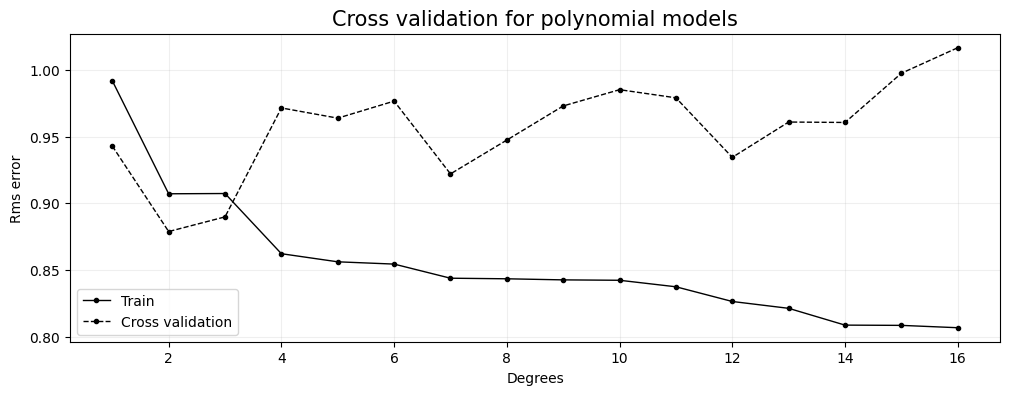

In [162]:
n_splits = 10
degrees = np.arange(1, 17)

rms_train_tot = np.empty(len(degrees))
rms_test_tot = np.empty(len(degrees))

for j, degree in enumerate(degrees):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)
    
    rms_train = np.empty(n_splits)
    rms_test = np.empty(n_splits)
    
    for (train_index, test_index), i in zip(kf.split(z), np.arange(n_splits)):
        z_train, z_test = z[train_index], z[test_index]
        mu_train, mu_test = mu_sample[train_index], mu_sample[test_index]
        dmu_train, dmu_test = dmu[train_index], dmu[test_index]
    
        model = PolynomialRegression(degree)
        model.fit(z_train, mu_train, dmu_train)
        
        # Remember, I want to evaluate the rms both on the training data and the test data!
        rms_train[i] = np.sqrt(np.sum((mu_train - model.predict(z_train))**2)/len(z_train))
        rms_test[i] = np.sqrt(np.sum((mu_test - model.predict(z_test))**2)/len(z_test))
    
    print('Degree: %i - Train: %.4f - test: %.4f' % (degree, np.median(rms_train), np.median(rms_test)))
    rms_train_tot[j] = np.median(rms_train)
    rms_test_tot[j] = np.median(rms_test)

print('\nThe best model is the one with %i degrees\n' % degrees[np.argmin(rms_test_tot)])

plt.figure(figsize=(12, 4))
plt.plot(degrees, rms_train_tot, lw = 1, color = 'black', ls = '-', marker = 'o', markersize = 3, label = 'Train')
plt.plot(degrees, rms_test_tot, lw = 1, color = 'black', ls = '--', marker = 'o', markersize = 3, label = 'Cross validation')
plt.xlabel('Degrees')
plt.ylabel('Rms error')
plt.title('Cross validation for polynomial models', fontsize = 15)
plt.grid(alpha = 0.2)
plt.legend()
plt.show()

One thing I've noticed, though, is that by running the code multiple times (leaving random_state = None) I obtain very different results:

In [157]:
n_splits = 10
degrees = np.arange(1, 17)

best_model = np.empty(100)

for index in np.arange(100):

    rms_train_tot = np.empty(len(degrees))
    rms_test_tot = np.empty(len(degrees))
    
    for j, degree in enumerate(degrees):
    
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=None)
        
        rms_train = np.empty(n_splits)
        rms_test = np.empty(n_splits)
        
        for (train_index, test_index), i in zip(kf.split(z), np.arange(n_splits)):
            z_train, z_test = z[train_index], z[test_index]
            mu_train, mu_test = mu_sample[train_index], mu_sample[test_index]
            dmu_train, dmu_test = dmu[train_index], dmu[test_index]
        
            model = PolynomialRegression(degree)
            model.fit(z_train, mu_train, dmu_train)
            
            # Remember, I want to evaluate the rms both on the training data and the test data!
            rms_train[i] = np.sqrt(np.sum((mu_train - model.predict(z_train))**2)/len(z_train))
            rms_test[i] = np.sqrt(np.sum((mu_test - model.predict(z_test))**2)/len(z_test))
        
        rms_train_tot[j] = np.median(rms_train)
        rms_test_tot[j] = np.median(rms_test)
    
    best_model[index] = degrees[np.argmin(rms_test_tot)]

value, count = np.unique(best_model, return_counts=True)

for v, c in zip(value, count):
    print('The %i-degrees model has been the best %i times' %(v, c)) 

The 1-degrees model has been the best 5 times
The 2-degrees model has been the best 18 times
The 3-degrees model has been the best 6 times
The 4-degrees model has been the best 14 times
The 5-degrees model has been the best 19 times
The 6-degrees model has been the best 4 times
The 7-degrees model has been the best 15 times
The 8-degrees model has been the best 6 times
The 9-degrees model has been the best 7 times
The 10-degrees model has been the best 3 times
The 11-degrees model has been the best 1 times
The 13-degrees model has been the best 2 times


This happened for n_splits = $2, 5, 10, 50$. By instead using n_splits = $100$, where every fold contained a single datapoint, the $5-$degrees model has been the best 100% of the times (even here, though, maybe letting the code run again would have given different results).

Maybe this means I don't have enough data. Let's see what the training curve can tell me:

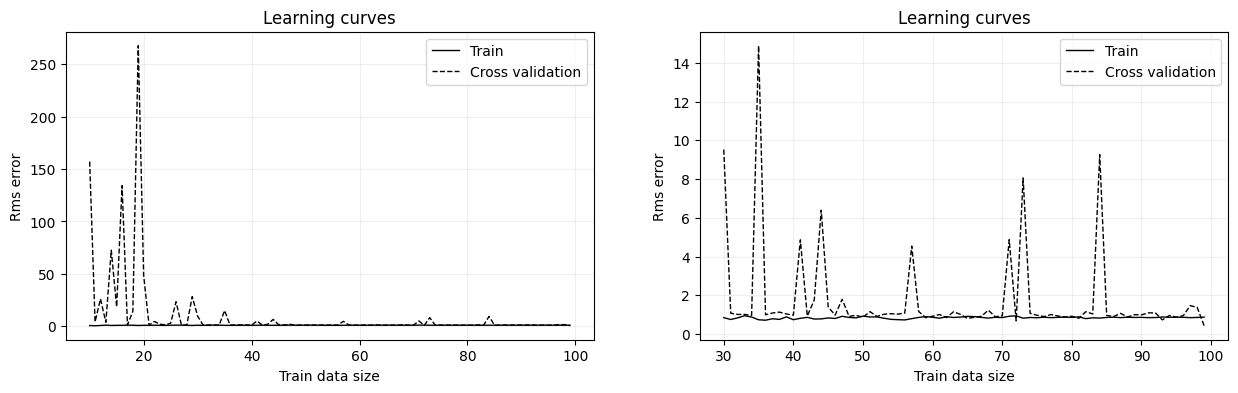

In [197]:
def splitting(n_data, train_size):     # For splitting the data in uneven chunks
    
    index = np.arange(100)
    np.random.shuffle(index)

    train_index = index[:train_size]
    test_index = index[train_size:]
    
    return train_index, test_index

np.random.seed()
degree = 5
train_size = np.array(np.arange(10, 100), dtype = int)

rms_train = np.empty(len(train_size))
rms_test = np.empty(len(train_size))

for i, ts in enumerate(train_size):

    train_index, test_index = splitting(len(z_sample), ts)
    
    #rms_train = np.empty(n_splits)
    #rms_test = np.empty(n_splits)

    z_train, z_test = z[train_index], z[test_index]
    mu_train, mu_test = mu_sample[train_index], mu_sample[test_index]
    dmu_train, dmu_test = dmu[train_index], dmu[test_index]

    model = PolynomialRegression(degree)
    model.fit(z_train, mu_train, dmu_train)

    rms_train[i] = np.sqrt(np.sum((mu_train - model.predict(z_train))**2)/len(z_train))
    rms_test[i] = np.sqrt(np.sum((mu_test - model.predict(z_test))**2)/len(z_test))
    
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].plot(train_size, rms_train, lw = 1, color = 'black', ls = '-', label = 'Train')
ax[0].plot(train_size, rms_test, lw = 1, color = 'black', ls = '--', label = 'Cross validation')
ax[0].set_xlabel('Train data size')
ax[0].set_ylabel('Rms error')
ax[0].set_title('Learning curves')
ax[0].grid(alpha = 0.2)
ax[0].legend()

ax[1].plot(train_size[20:], rms_train[20:], lw = 1, color = 'black', ls = '-', label = 'Train')
ax[1].plot(train_size[20:], rms_test[20:], lw = 1, color = 'black', ls = '--', label = 'Cross validation')
ax[1].set_xlabel('Train data size')
ax[1].set_ylabel('Rms error')
ax[1].set_title('Learning curves')
ax[1].grid(alpha = 0.2)
ax[1].legend()

plt.show()